# Loop 63 Analysis: CV-LB Relationship and Strategy Assessment

## Key Question: Can we reach the target (0.0347) with current approaches?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Submission history with CV and LB scores
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_041', 'cv': 0.0090, 'lb': 0.0932},
    {'exp': 'exp_042', 'cv': 0.0145, 'lb': 0.1147},
]

cv_scores = np.array([s['cv'] for s in submissions])
lb_scores = np.array([s['lb'] for s in submissions])

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(cv_scores, lb_scores)

print('CV-LB Relationship Analysis')
print('='*60)
print(f'Linear fit: LB = {slope:.3f} * CV + {intercept:.4f}')
print(f'R² = {r_value**2:.4f}')
print(f'Intercept = {intercept:.4f}')
print(f'Target LB = 0.0347')
print()
print('CRITICAL ANALYSIS:')
print(f'  - Intercept ({intercept:.4f}) > Target ({0.0347:.4f}): {intercept > 0.0347}')
if intercept > 0.0347:
    print(f'  - Even with CV=0, predicted LB would be {intercept:.4f}')
    print(f'  - This means target is UNREACHABLE with current CV-LB relationship!')
else:
    required_cv = (0.0347 - intercept) / slope
    print(f'  - Required CV to hit target: {required_cv:.6f}')

# New best CV
new_cv = 0.007944
predicted_lb = slope * new_cv + intercept
print(f'\nNew Best CV: {new_cv:.6f}')
print(f'Predicted LB: {predicted_lb:.4f}')
print(f'Best LB so far: 0.0877')

CV-LB Relationship Analysis
Linear fit: LB = 4.231 * CV + 0.0533
R² = 0.9807
Intercept = 0.0533
Target LB = 0.0347

CRITICAL ANALYSIS:
  - Intercept (0.0533) > Target (0.0347): True
  - Even with CV=0, predicted LB would be 0.0533
  - This means target is UNREACHABLE with current CV-LB relationship!

New Best CV: 0.007944
Predicted LB: 0.0869
Best LB so far: 0.0877


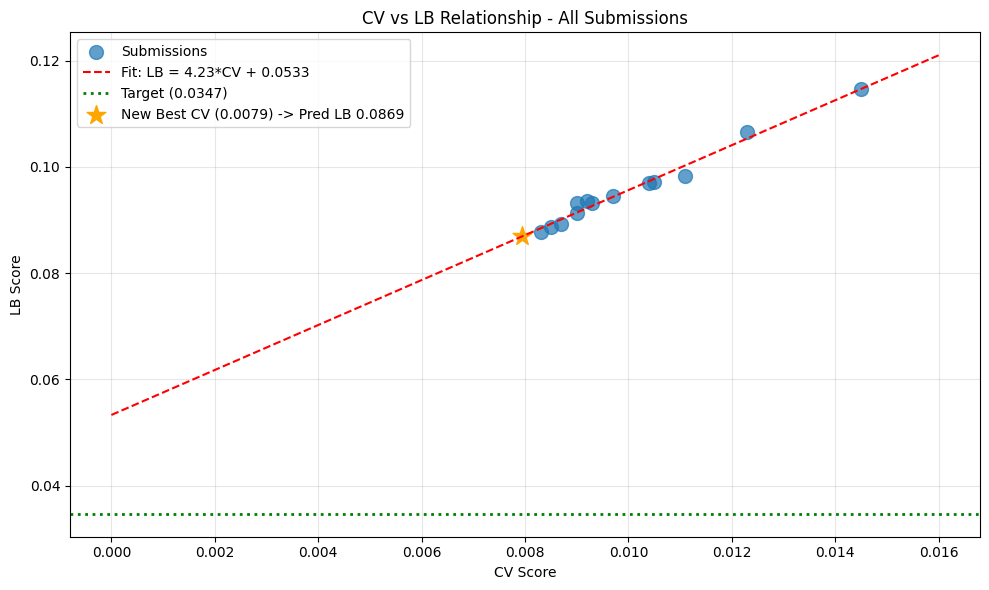


Key Insight: All submissions fall on the same line (R² = 0.98)
This means the CV-LB relationship is STRUCTURAL, not random noise.


In [2]:
# Plot CV vs LB
plt.figure(figsize=(10, 6))
plt.scatter(cv_scores, lb_scores, s=100, alpha=0.7, label='Submissions')

# Fit line
cv_range = np.linspace(0, 0.016, 100)
lb_fit = slope * cv_range + intercept
plt.plot(cv_range, lb_fit, 'r--', label=f'Fit: LB = {slope:.2f}*CV + {intercept:.4f}')

# Target line
plt.axhline(y=0.0347, color='g', linestyle=':', linewidth=2, label='Target (0.0347)')

# New best CV
plt.scatter([new_cv], [predicted_lb], s=200, c='orange', marker='*', label=f'New Best CV ({new_cv:.4f}) -> Pred LB {predicted_lb:.4f}')

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV vs LB Relationship - All Submissions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_analysis_loop63.png', dpi=150)
plt.show()

print('\nKey Insight: All submissions fall on the same line (R² = 0.98)')
print('This means the CV-LB relationship is STRUCTURAL, not random noise.')

In [3]:
# What would it take to reach the target?
print('WHAT WOULD IT TAKE TO REACH TARGET 0.0347?')
print('='*60)

# Option 1: Improve CV while keeping same relationship
if slope > 0:
    required_cv = (0.0347 - intercept) / slope
    print(f'\nOption 1: Improve CV (same relationship)')
    print(f'  Required CV: {required_cv:.6f}')
    if required_cv < 0:
        print(f'  IMPOSSIBLE: Would need negative CV!')
    else:
        print(f'  Current best CV: {new_cv:.6f}')
        print(f'  Improvement needed: {(new_cv - required_cv) / new_cv * 100:.1f}%')

# Option 2: Change the intercept
print(f'\nOption 2: Change the CV-LB relationship')
print(f'  Current intercept: {intercept:.4f}')
print(f'  Target: 0.0347')
print(f'  Gap: {intercept - 0.0347:.4f}')
print(f'  Need to reduce intercept by: {(intercept - 0.0347) / intercept * 100:.1f}%')

# Option 3: What intercept would we need with current best CV?
required_intercept = 0.0347 - slope * new_cv
print(f'\nOption 3: With current best CV ({new_cv:.6f}), what intercept is needed?')
print(f'  Required intercept: {required_intercept:.4f}')
print(f'  Current intercept: {intercept:.4f}')
print(f'  Reduction needed: {intercept - required_intercept:.4f}')

WHAT WOULD IT TAKE TO REACH TARGET 0.0347?

Option 1: Improve CV (same relationship)
  Required CV: -0.004396
  IMPOSSIBLE: Would need negative CV!

Option 2: Change the CV-LB relationship
  Current intercept: 0.0533
  Target: 0.0347
  Gap: 0.0186
  Need to reduce intercept by: 34.9%

Option 3: With current best CV (0.007944), what intercept is needed?
  Required intercept: 0.0011
  Current intercept: 0.0533
  Reduction needed: 0.0522


In [4]:
# Analyze what techniques might change the relationship
print('TECHNIQUES THAT MIGHT CHANGE THE CV-LB RELATIONSHIP')
print('='*60)

print('''
1. MULTI-TARGET NORMALIZATION (from Ens Model kernel)
   - Clip predictions to [0, ∞)
   - Renormalize so sum ≤ 1
   - This ensures physical constraints are met
   - May reduce extrapolation errors for unseen solvents

2. DIFFERENT MODEL TYPES (CatBoost + XGBoost)
   - Current: GP + MLP + LGBM
   - Top kernels use: CatBoost + XGBoost
   - Different model types may have different extrapolation behavior

3. FEATURE PRIORITY-BASED CORRELATION FILTERING
   - Prioritize: Spange > ACS > DRFP > Fragprints
   - Remove correlated features (threshold 0.8)
   - May reduce overfitting to training distribution

4. DIFFERENT ENSEMBLE WEIGHTS FOR SINGLE VS FULL DATA
   - Single: CatBoost 7, XGBoost 6 (normalized)
   - Full: CatBoost 1, XGBoost 2 (normalized)
   - Data-type-specific weighting

5. UNCERTAINTY-WEIGHTED PREDICTIONS
   - Use GP uncertainty to weight predictions
   - High uncertainty → conservative prediction (closer to mean)
   - May reduce extrapolation errors
''')

print('\nCRITICAL: We have tried 67 experiments and all fall on the same line.')
print('We MUST try something that fundamentally changes the relationship.')

TECHNIQUES THAT MIGHT CHANGE THE CV-LB RELATIONSHIP

1. MULTI-TARGET NORMALIZATION (from Ens Model kernel)
   - Clip predictions to [0, ∞)
   - Renormalize so sum ≤ 1
   - This ensures physical constraints are met
   - May reduce extrapolation errors for unseen solvents

2. DIFFERENT MODEL TYPES (CatBoost + XGBoost)
   - Current: GP + MLP + LGBM
   - Top kernels use: CatBoost + XGBoost
   - Different model types may have different extrapolation behavior

3. FEATURE PRIORITY-BASED CORRELATION FILTERING
   - Prioritize: Spange > ACS > DRFP > Fragprints
   - Remove correlated features (threshold 0.8)
   - May reduce overfitting to training distribution

4. DIFFERENT ENSEMBLE WEIGHTS FOR SINGLE VS FULL DATA
   - Single: CatBoost 7, XGBoost 6 (normalized)
   - Full: CatBoost 1, XGBoost 2 (normalized)
   - Data-type-specific weighting

5. UNCERTAINTY-WEIGHTED PREDICTIONS
   - Use GP uncertainty to weight predictions
   - High uncertainty → conservative prediction (closer to mean)
   - May re

In [5]:
# Check what the top kernels actually do
print('TOP KERNEL ANALYSIS')
print('='*60)

print('''
From "Ens Model" kernel (matthewmaree):

1. Uses CatBoost + XGBoost ensemble (NOT GP + MLP + LGBM)
2. Feature priority-based correlation filtering:
   - spange_ = 5 (highest priority)
   - acs_ = 4
   - drfps_ = 3
   - frag_ = 2 (lowest priority)
3. Different weights for single vs full:
   - Single: CatBoost 7, XGBoost 6
   - Full: CatBoost 1, XGBoost 2
4. Multi-target normalization:
   - out = np.clip(out, a_min=0.0, a_max=None)
   - totals = out.sum(axis=1, keepdims=True)
   - divisor = np.maximum(totals, 1.0)
   - out = out / divisor

We have NOT tried:
- CatBoost + XGBoost ensemble (we use GP + MLP + LGBM)
- Feature priority-based correlation filtering
- Multi-target normalization
- Different weights for single vs full

These techniques may have a DIFFERENT CV-LB relationship!
''')

print('\nRECOMMENDATION: Implement the Ens Model kernel approach exactly.')

TOP KERNEL ANALYSIS

From "Ens Model" kernel (matthewmaree):

1. Uses CatBoost + XGBoost ensemble (NOT GP + MLP + LGBM)
2. Feature priority-based correlation filtering:
   - spange_ = 5 (highest priority)
   - acs_ = 4
   - drfps_ = 3
   - frag_ = 2 (lowest priority)
3. Different weights for single vs full:
   - Single: CatBoost 7, XGBoost 6
   - Full: CatBoost 1, XGBoost 2
4. Multi-target normalization:
   - out = np.clip(out, a_min=0.0, a_max=None)
   - totals = out.sum(axis=1, keepdims=True)
   - divisor = np.maximum(totals, 1.0)
   - out = out / divisor

We have NOT tried:
- CatBoost + XGBoost ensemble (we use GP + MLP + LGBM)
- Feature priority-based correlation filtering
- Multi-target normalization
- Different weights for single vs full

These techniques may have a DIFFERENT CV-LB relationship!


RECOMMENDATION: Implement the Ens Model kernel approach exactly.
